Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d, lower_triangular, decor_modules
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.training import decor_train, bp_train
import argparse
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_results(init_model, model, dataloader, device):

    for batch in dataloader:
        init_model.forward(batch[0].to(device))
        model.forward(batch[0].to(device))
        init_modules = decor_modules(init_model)
        modules = decor_modules(model)
        for i, (imod, mod) in enumerate(zip(init_modules, modules)):
        
            state = imod.decor_state            
            Ci = (state.T @ state) / len(state)
            Ci = Ci.detach().numpy()

            state = mod.decor_state            
            C = (state.T @ state) / len(state)
            C = C.detach().numpy()

            plt.subplot(2, len(modules), i+1)
            plt.title(f'layer {i+1}')
            plt.xlabel('$x_i x_j$')
            plt.hist([lower_triangular(Ci, offset=-1), lower_triangular(C, offset=-1)], bins=30, label=['correlated', 'decorrelated'])
            plt.subplot(2, len(modules), i+1+len(modules))
            plt.hist([np.diagonal(Ci), np.diagonal(C)], bins=30, label=['correlated', 'decorrelated'])
            plt.xlabel('$x_i^2$')
            print(f'layer {i+1} mean covariance before decorrelation: {np.mean(lower_triangular(Ci, offset=-1)):.2f}')
            print(f'layer {i+1} mean covariance after decorrelation: {np.mean(lower_triangular(C, offset=-1)):.2f}')
            print(f'layer {i+1} mean variance before decorrelation: {np.mean(np.diagonal(Ci)):.2f}')
            print(f'layer {i+1} mean variance after decorrelation: {np.mean(np.diagonal(C)):.2f}')
        break
    plt.legend();

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [4]:
args = argparse.Namespace(lr=1e-3, eta=1e-2, decor_lr=1e0, whiten=True, epochs=30)

class Model(nn.Sequential):
    def __init__(self, in_features, eta, whiten):
        super().__init__(DecorLinear(in_features, 100, decor_bias=False, kappa=eta, whiten=whiten),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_bias=False, kappa=eta, whiten=whiten)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, whiten):
#         super().__init__(Decorrelation(in_features, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(in_features),
#                         nn.Linear(in_features, 100),
#                         nn.LeakyReLU(),
#                         Decorrelation(100, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(100),
#                         nn.Linear(100, 10)
#                         )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))


model = Model(784, eta=args.eta, whiten=args.whiten).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device) # OR BP_TRAIN

epoch 0  	time:0.000 s	bp loss: 2.528634	decorrelation loss: 6.862281
epoch 1  	time:0.359 s	bp loss: 2.097114	decorrelation loss: 10.948387
epoch 2  	time:0.487 s	bp loss: 1.352512	decorrelation loss: 28.465385
epoch 3  	time:0.354 s	bp loss: 0.915049	decorrelation loss: 24.342543
epoch 4  	time:0.427 s	bp loss: 0.714140	decorrelation loss: 17.583656
epoch 5  	time:0.362 s	bp loss: 0.608197	decorrelation loss: 13.477736
epoch 6  	time:0.373 s	bp loss: 0.544145	decorrelation loss: 10.955321
epoch 7  	time:0.375 s	bp loss: 0.499091	decorrelation loss: 9.179371
epoch 8  	time:0.375 s	bp loss: 0.442458	decorrelation loss: 8.218740
epoch 9  	time:0.363 s	bp loss: 0.409745	decorrelation loss: 9.131345
epoch 10 	time:0.350 s	bp loss: 0.386336	decorrelation loss: 7.464979
epoch 11 	time:0.601 s	bp loss: 0.354060	decorrelation loss: 6.577610
epoch 12 	time:0.375 s	bp loss: 0.327519	decorrelation loss: 5.973293
epoch 13 	time:0.361 s	bp loss: 0.313750	decorrelation loss: 5.505774
epoch 14 	time

layer 1:

mean covariance before decorrelation: 0.57
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.21
mean variance after decorrelation: 0.52

layer 2:

mean covariance before decorrelation: 0.03
mean variance before decorrelation: 0.12

mean covariance after decorrelation: 0.07
mean variance after decorrelation: 0.92



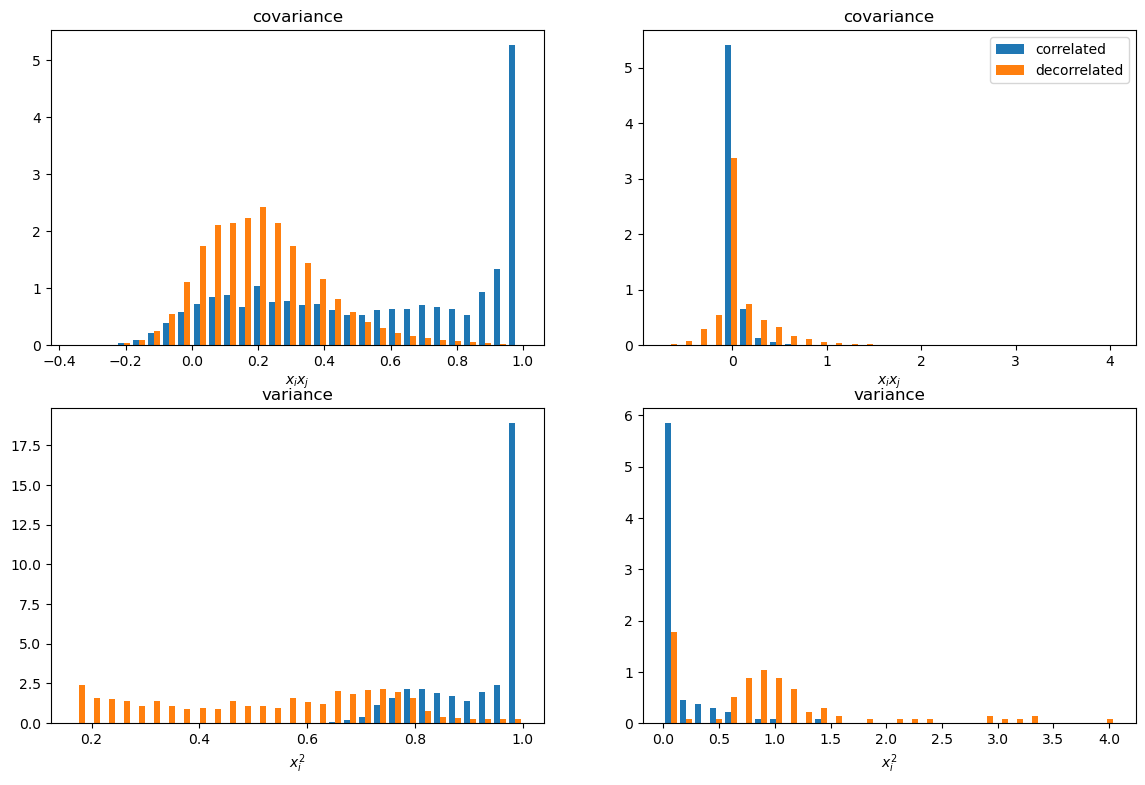

In [5]:
init_model = Model(784, eta=args.eta, whiten=args.whiten).to(device) # deepcopy does not work
plot_correlations(init_model, model, train_loader, device)

In [6]:
len(model)

3